In [3]:
import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np
import pickle

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow_addons.metrics import F1Score

In [4]:
# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
# MAX_AUDIO_FILES = 10000
EPOCHS=10

In [6]:
# Load metadata file
train = pd.read_csv('Downloads/dataset/train_metadata.csv',)

# Limit the number of training samples and classes
# First, only use high quality samples
#train = train.query('rating>= 4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least 200 recordings with a rating above 4 to be considered common
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= 175] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 19
NUMBER OF SAMPLES IN TRAIN DATA: 7073
LABELS: ['barswa', 'blakit1', 'cohmar1', 'colsun2', 'combul2', 'combuz1', 'comsan', 'eaywag1', 'eubeat1', 'gnbcam2', 'greegr', 'hoopoe', 'litegr', 'rbsrob1', 'rerswa1', 'somgre1', 'thrnig1', 'wlwwar', 'woosan']


In [7]:
# saving labels 
with open('LABELS.pkl','wb') as f:
    pickle.dump(LABELS,f)

In [8]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)

# Define a function that splits an audio file, 
# extracts spectrograms and saves them in a working directory
def get_spectrograms(filepath, primary_label, output_dir):
    
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
        
    return saved_samples

print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))

FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 7073


In [9]:
input_dir = r'C:\Users\Mihika\Downloads\train_audio'
output_dir = 'C:/User/Mihika/Downloads/dataset/output/melspectrogram_dataset'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(input_dir,row.primary_label,row.file_name)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████████████████████████████████████████████████████████████████████████| 7073/7073 [03:58<00:00, 29.67it/s]

SUCCESSFULLY EXTRACTED 17369 SPECTROGRAMS


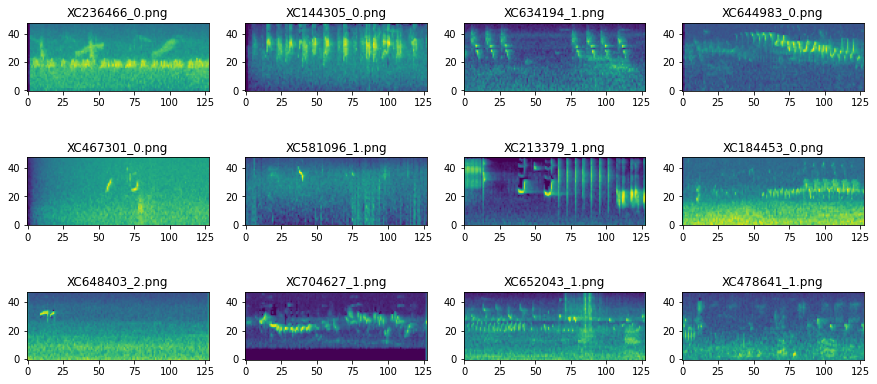

In [10]:
# Plot the first 12 spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

In [11]:
# Parse all samples and add spectrograms into train data, primary_labels into label data
train_specs, train_labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        # Open image
        spec = Image.open(path)

        # Convert to numpy array
        spec = np.array(spec, dtype='float32')
        
        # Normalize between 0.0 and 1.0
        # and exclude samples with nan 
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)

        # Add to train data
        if len(train_specs) == 0:
            train_specs = spec
        else:
            train_specs = np.vstack((train_specs, spec))

        # Add to label data
        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(train_labels) == 0:
            train_labels = target
        else:
            train_labels = np.vstack((train_labels, target))

100%|████████████████████████████████████████████████████████████████████████████| 17369/17369 [19:58<00:00, 14.49it/s]


In [12]:
f1_score=F1Score(num_classes=len(LABELS),average='macro',name='f1_score')

In [13]:
# Make sure your experiments are reproducible
tf.random.set_seed(RANDOM_SEED)

# Build a simple model as a sequence of  convolutional blocks.
# Each block has the sequence CONV --> RELU --> BNORM --> MAXPOOL.
# Finally, perform global average pooling and add 2 dense layers.
# The last layer is our classification layer and is softmax activated.
# (Well it's a multi-label task so sigmoid might actually be a better choice)
model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
        
    
    
#     # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),   
#     tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])



print('MODEL HAS {} PARAMETERS.'.format(model.count_params()))

MODEL HAS 409363 PARAMETERS.


In [14]:
# Compile the model and specify optimizer, loss and metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])

In [15]:
# Add callbacks to reduce the learning rate if needed, early stopping, and checkpoint saving
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  mode='max',
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=20),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_f1_score',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

In [16]:
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))
    
    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')
    
    #accuracy
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
    
#     #f1_score
#     plt.plot(range(len(his)),his['f1_score'],color='steelblue',label='training_f1')
#     plt.plot(range(len(his)),his['val_f1_score'],color='maroon',label='validation_f1')
    
    plt.legend()
    plt.title('accuracy')
    
    plt.show() 

Epoch 1/10
434/435 [============================>.] - ETA: 0s - loss: 2.0082 - accuracy: 0.4212 - f1_score: 0.3755
Epoch 1: val_f1_score improved from -inf to 0.04201, saving model to best_model.h5
435/435 [==============================] - 57s 118ms/step - loss: 2.0079 - accuracy: 0.4212 - f1_score: 0.3755 - val_loss: 3.4725 - val_accuracy: 0.1123 - val_f1_score: 0.0420 - lr: 0.0010
Epoch 2/10
434/435 [============================>.] - ETA: 0s - loss: 1.3267 - accuracy: 0.6195 - f1_score: 0.5827
Epoch 2: val_f1_score improved from 0.04201 to 0.32494, saving model to best_model.h5
435/435 [==============================] - 52s 119ms/step - loss: 1.3266 - accuracy: 0.6195 - f1_score: 0.5827 - val_loss: 2.9333 - val_accuracy: 0.3495 - val_f1_score: 0.3249 - lr: 0.0010
Epoch 3/10
434/435 [============================>.] - ETA: 0s - loss: 1.1071 - accuracy: 0.6928 - f1_score: 0.6678
Epoch 3: val_f1_score improved from 0.32494 to 0.62518, saving model to best_model.h5
435/435 [=============

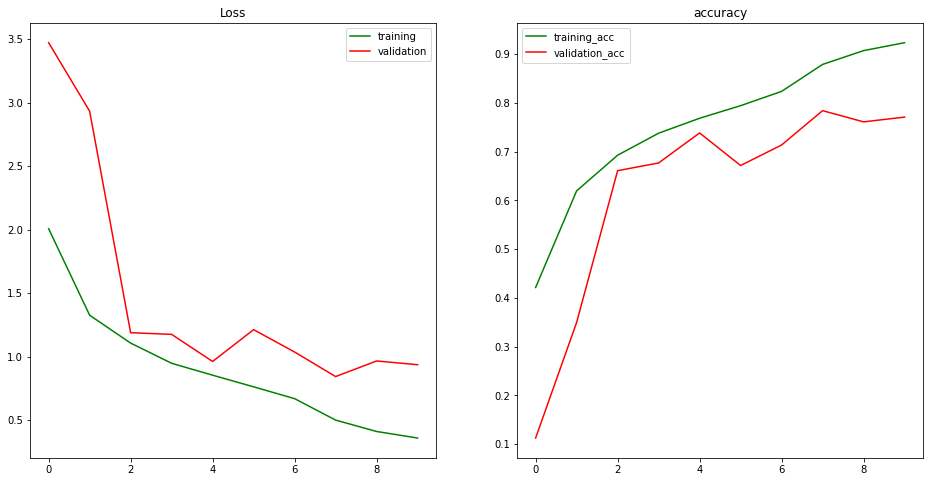

In [17]:
# Let's train the model for a few epochs
his=model.fit(train_specs, 
          train_labels,
          batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=EPOCHS)

plot_history(his)


In [29]:
# Make sure your experiments are reproducible
tf.random.set_seed(RANDOM_SEED)

# Build a simple model as a sequence of  convolutional blocks.
# Each block has the sequence CONV --> RELU --> BNORM --> MAXPOOL.
# Finally, perform global average pooling and add 2 dense layers.
# The last layer is our classification layer and is softmax activated.
# (Well it's a multi-label task so sigmoid might actually be a better choice)
model2 = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
        
    
    
#     # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),   
#     tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])



print('MODEL HAS {} PARAMETERS.'.format(model2.count_params()))

MODEL HAS 117075 PARAMETERS.


In [31]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy',f1_score])

# Add callbacks to reduce the learning rate if needed, early stopping, and checkpoint saving
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score',
                                                  mode='max',
                                                  patience=2, 
                                                  verbose=1, 
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=20),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.h5', 
                                                mode='max',
                                                monitor='val_f1_score',
                                                verbose=0,
                                                save_best_only=True)]

Epoch 1/10
435/435 [==============================] - 69s 146ms/step - loss: 2.1861 - accuracy: 0.3617 - f1_score: 0.4079 - val_loss: 2.9465 - val_accuracy: 0.1667 - val_f1_score: 0.0868 - lr: 0.0010
Epoch 2/10
435/435 [==============================] - 62s 142ms/step - loss: 1.4965 - accuracy: 0.5665 - f1_score: 0.5204 - val_loss: 1.2746 - val_accuracy: 0.6390 - val_f1_score: 0.6052 - lr: 0.0010
Epoch 3/10
435/435 [==============================] - 63s 144ms/step - loss: 1.2667 - accuracy: 0.6422 - f1_score: 0.6047 - val_loss: 1.1689 - val_accuracy: 0.6724 - val_f1_score: 0.6407 - lr: 0.0010
Epoch 4/10
435/435 [==============================] - 62s 143ms/step - loss: 1.1262 - accuracy: 0.6858 - f1_score: 0.6546 - val_loss: 1.2431 - val_accuracy: 0.6531 - val_f1_score: 0.6289 - lr: 0.0010
Epoch 5/10
435/435 [==============================] - 64s 147ms/step - loss: 1.0235 - accuracy: 0.7157 - f1_score: 0.6889 - val_loss: 1.0609 - val_accuracy: 0.7018 - val_f1_score: 0.6750 - lr: 0.0010


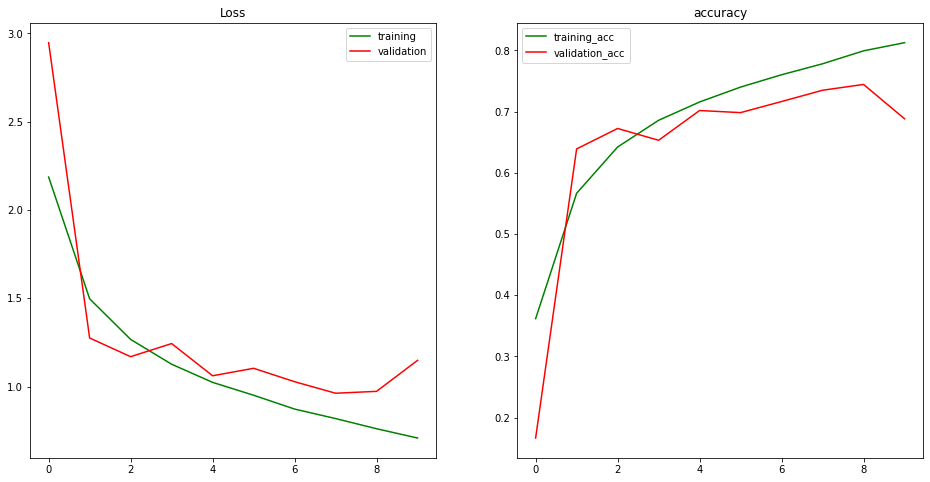

In [32]:
his2=model2.fit(train_specs, 
          train_labels,
          batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          verbose=1,
          epochs=EPOCHS)

plot_history(his2)

In [34]:
# Pick a soundscape
soundscape_path = r'C:\Users\Mihika\Downloads\28933_SSW_20170408.ogg\28933_SSW_20170408.ogg'

# Open it with librosa
sig, rate = librosa.load(soundscape_path, sr=SAMPLE_RATE)

# Store results so that we can analyze them later
data = {'row_id': [], 'prediction': [], 'score': []}

# Split signal into 5-second chunks
# Just like we did before (well, this could actually be a seperate function)
sig_splits = []
for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
    split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

    # End of signal?
    if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
        break

    sig_splits.append(split)
    
# Get the spectrograms and run inference on each of them
# This should be the exact same process as we used to
# generate training samples!
seconds, scnt = 0, 0
for chunk in sig_splits:
    
    # Keep track of the end time of each chunk
    seconds += 5
        
    # Get the spectrogram
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=hop_length, 
                                              n_mels=SPEC_SHAPE[0], 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 

    # Normalize to match the value range we used during training.
    # That's something you should always double check!
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    
    # Add channel axis to 2D array
    mel_spec = np.expand_dims(mel_spec, -1)

    # Add new dimension for batch size
    mel_spec = np.expand_dims(mel_spec, 0)
    
    # Predict
    p = 0.5*model.predict(mel_spec)[0] + 0.5*model2.predict(mel_spec)[0]
    
    
    # Get highest scoring species
    idx = p.argmax()
    species = LABELS[idx]
    score = p[idx]
    
    # Prepare submission entry
    data['row_id'].append(soundscape_path.split(os.sep)[-1].rsplit('_', 1)[0] + 
                          '_' + str(seconds))    
    
    # Decide if it's a "nocall" or a species by applying a threshold
    if score > 0.45:
        data['prediction'].append(species)
        scnt += 1
    else:
        data['prediction'].append('nocall')
        
    # Add the confidence score as well
    data['score'].append(score)
        
print('SOUNSCAPE ANALYSIS DONE. FOUND {} BIRDS.'.format(scnt))

1/1 [==============================] - 0s 44ms/step
SOUNSCAPE ANALYSIS DONE. FOUND 27 BIRDS.


In [36]:
# Make a new data frame
results = pd.DataFrame(data, columns = ['row_id', 'prediction', 'score'])

# Merge with ground truth so we can inspect
gt = pd.read_csv(r'C:\Users\Mihika\Downloads\train_soundscape_labels.csv',)
results = pd.merge(gt, results, on='row_id')

# Let's look at the first 50 entries
results.head(70)

,row_id,site,audio_id,seconds,birds,prediction,score
0,28933_SSW_5,SSW,28933,5,sonspa,nocall,0.288229
1,28933_SSW_10,SSW,28933,10,rewbla,nocall,0.258012
2,28933_SSW_15,SSW,28933,15,sonspa,nocall,0.338010
3,28933_SSW_20,SSW,28933,20,sonspa,nocall,0.296297
4,28933_SSW_25,SSW,28933,25,sonspa,nocall,0.222182
...,...,...,...,...,...,...,...
65,28933_SSW_330,SSW,28933,330,cangoo,nocall,0.174072
66,28933_SSW_335,SSW,28933,335,nocall,nocall,0.188324
67,28933_SSW_340,SSW,28933,340,nocall,nocall,0.136376
68,28933_SSW_345,SSW,28933,345,cangoo,nocall,0.237927
